In [1]:
from xopt.generators.bayesian.upper_confidence_bound import TDUpperConfidenceBoundGenerator
from xopt.vocs import VOCS
from xopt.evaluator import Evaluator
import numpy as np

In [2]:
# test evaluate function and vocs
import time
start_time = time.time()
def f(inputs):
    x_ = inputs["x"]
    current_time = time.time()
    t_ = current_time - start_time
    y_ = 5*(x_ - t_*1e-2)**2
    return {"y":y_, "time":current_time}

variables = {"x":[-1,1]}
objectives = {"y": "MINIMIZE"}

vocs = VOCS(variables=variables, objectives=objectives)
print(vocs)

evaluator = Evaluator(function=f)
generator = TDUpperConfidenceBoundGenerator(vocs)
generator.options.n_initial = 3
generator.options.acq.added_time=2.0
generator.options.acq.beta = 2.0
#generator.options.model.use_low_noise_prior = True
generator.options


variables={'x': [-1.0, 1.0]} constraints={} objectives={'y': 'MINIMIZE'} constants={} linked_variables={}


TDUCBOptions(optim=OptimOptions(num_restarts=5, raw_samples=20, sequential=True, use_nearby_initial_points=True), acq=TDUpperConfidenceBoundOptions(proximal_lengthscales=None, monte_carlo_samples=512, added_time=2.0, beta=2.0), model=ModelOptions(use_conservative_prior_lengthscale=False, use_conservative_prior_mean=False, use_low_noise_prior=False), n_initial=3)

In [3]:
from xopt import Xopt
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

X.step()

for _ in range(20):
    X.step()
    time.sleep(0.1)

print(X.generator.generate(1))

          x
0  0.433982


In [4]:
X.data

,x,y,time,xopt_error,xopt_error_str
1,-0.810013,3.447670,1.659125e+09,False,
2,0.360674,0.579038,1.659125e+09,False,
3,0.930312,4.139987,1.659125e+09,False,
4,0.136914,0.046474,1.659125e+09,False,
5,0.241135,0.161139,1.659125e+09,False,
6,-0.087438,0.144733,1.659125e+09,False,
7,0.183870,0.032047,1.659125e+09,False,
8,-0.069140,0.188355,1.659125e+09,False,
9,0.184388,0.007358,1.659125e+09,False,
10,0.081339,0.036850,1.659125e+09,False,


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


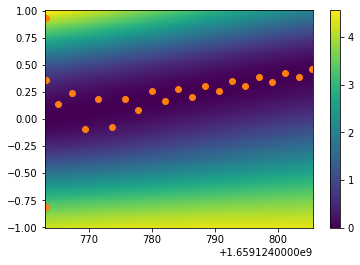

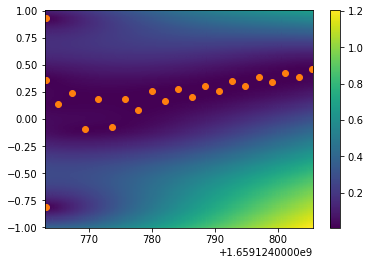

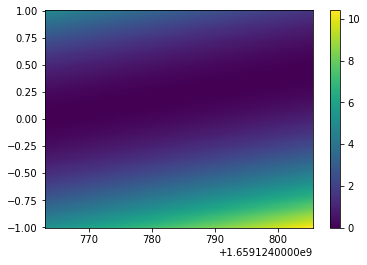

In [5]:
# plot model
import torch
from matplotlib import pyplot as plt  # plot model predictions
data = X.data

xbounds = generator.vocs.bounds
tbounds = [data["time"].min(), data["time"].max()]

def gt(inpts):
    return 5*(inpts[:,1] - (inpts[:,0] - start_time)*1e-2)**2

model = X.generator.model
n = 200
t = torch.linspace(*tbounds, n, dtype=torch.double)
x = torch.linspace(*xbounds.flatten(), n, dtype=torch.double)
tt, xx = torch.meshgrid(t, x)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (tt, xx)]).double()

#NOTE: the model inputs are such that t is the last dimension
gp_pts = torch.flip(pts, dims=[-1])

gt_vals = gt(pts)

with torch.no_grad():
    post = model.posterior(gp_pts)

    mean = post.mean
    std = torch.sqrt(post.variance)

    fig, ax = plt.subplots()
    c = ax.pcolor(tt, xx, mean.reshape(n,n))
    fig.colorbar(c)

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(tt, xx, std.reshape(n,n))
    fig2.colorbar(c)

    ax.plot(data["time"].to_numpy(), data["x"].to_numpy(),"oC1")
    ax2.plot(data["time"].to_numpy(), data["x"].to_numpy(),"oC1")

    fig3, ax3 = plt.subplots()
    c = ax3.pcolor(tt, xx, gt_vals.reshape(n,n))
    fig3.colorbar(c)

In [6]:
list(model.named_parameters())

[('models.0.likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([1.0000e-04], dtype=torch.float64, requires_grad=True)),
 ('models.0.mean_module.constant',
  Parameter containing:
  tensor([3.0235], dtype=torch.float64, requires_grad=True)),
 ('models.0.covar_module.raw_outputscale',
  Parameter containing:
  tensor(4.0066, dtype=torch.float64, requires_grad=True)),
 ('models.0.covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[-0.4066,  1.4881]], dtype=torch.float64, requires_grad=True))]

46.317529916763306


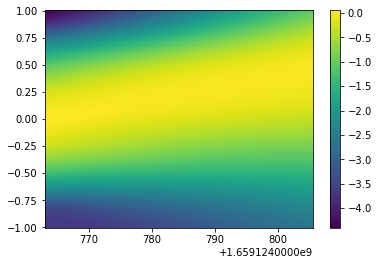

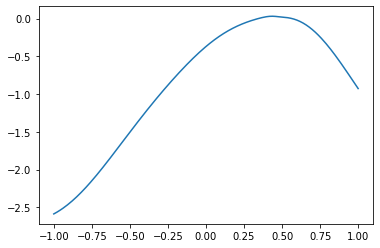

In [7]:
# plot the acquisition function
# note that target time is only updated during the generate call
target_time = generator.target_prediction_time
print(target_time-start_time)
my_acq_func = generator.get_acquisition(model)

with torch.no_grad():
    acq_pts = x.unsqueeze(-1).unsqueeze(-1)
    full_acq = my_acq_func.acq_func(gp_pts.unsqueeze(1))
    fixed_acq = my_acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(tt, xx, full_acq.reshape(n,n))
    fig.colorbar(c)

    fi2, ax2 = plt.subplots()
    ax2.plot(x.flatten(), fixed_acq.flatten())